# Analyse de la calibration données WiFi

**Données reçues le 27 août 2025 par Jay**

---

**Objectif :** Estimation de la stabilité d'une calibration entre bornes
**Auteur :** Xavier Prudent  
**Date** 27 août 2025  
**Contact :** [prudentxavier@gmail.com](mailto:prudentxavier@gmail.com)

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# Setting the working directory to the parent directory of the current script
import os
from pathlib import Path
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import matplotlib.pyplot as plt

from include import print_stats, plot_metrics, read_data, wrangle_data, build_metrics, print_stats_small, plot_metrics_multi 

#print(os.getcwd())
#script_dir = os.getcwd() + "/2025-01/define_query/"
#print(script_dir)
#os.chdir(script_dir)



In [51]:
print(os.getcwd())

/home/xavier/Desktop/Personnel/Travail/Analyste/Projets/Reelyactive/2025-01/analyse_calibration


In [52]:

# Load data 
data_file = os.getcwd() + "/../data/raddecs-f1.csv"
print(data_file)

df = read_data(data_file)

df = wrangle_data(df)

/home/xavier/Desktop/Personnel/Travail/Analyste/Projets/Reelyactive/2025-01/analyse_calibration/../data/raddecs-f1.csv


Statistiques générales sur les données:

In [53]:
# Data summary
print(df.head())
print()
print(df.dtypes)
print()
print_stats(df)

                timestamp transmitterId    receiverId  rssi
0 2025-06-15 09:59:59.589  4a5761a2256a  02a3bd59e2dc   -77
1 2025-06-15 09:59:59.589  a6c209f6faee  02a3bd59e2dc   -81
2 2025-06-15 09:59:59.588  52853d9f675a  02a3e5351a16   -69
3 2025-06-15 09:59:59.588  52f810314e73  02a3e5351a16   -67
4 2025-06-15 09:59:59.566  020000000000  02a3e5351a16   -67

timestamp        datetime64[ns]
transmitterId            object
receiverId               object
rssi                      int64
dtype: object

Nombre de lignes : 276562
Nombre d'émetteurs uniques : 254703
Nombre de récepteurs uniques : 7
Date/heure min : 2025-06-15 08:30:00.236000
Date/heure max : 2025-06-15 09:59:59.589000


Dans un premier temps, les différents récepteurs ne sont pas considérés séparemment.
Les métriques de sélection dont définies et ajoutées dans le fichier brut:

In [54]:
df = build_metrics(df)
print(df.head())

Calculating number of measurements per transmitter...
Calculating time window and max RSSI per transmitter...
Extracting second character of transmitterId...
                timestamp transmitterId    receiverId  rssi  nb_counts  \
0 2025-06-15 09:59:59.589  4a5761a2256a  02a3bd59e2dc   -77          1   
1 2025-06-15 09:59:59.589  a6c209f6faee  02a3bd59e2dc   -81          1   
2 2025-06-15 09:59:59.588  52853d9f675a  02a3e5351a16   -69          1   
3 2025-06-15 09:59:59.588  52f810314e73  02a3e5351a16   -67          1   
4 2025-06-15 09:59:59.566  020000000000  02a3e5351a16   -67        106   

   time_window  max_rssi digit_2  
0        0.000       -77       a  
1        0.000       -81       6  
2        0.000       -69       2  
3        0.000       -67       2  
4     5378.166       -59       2  


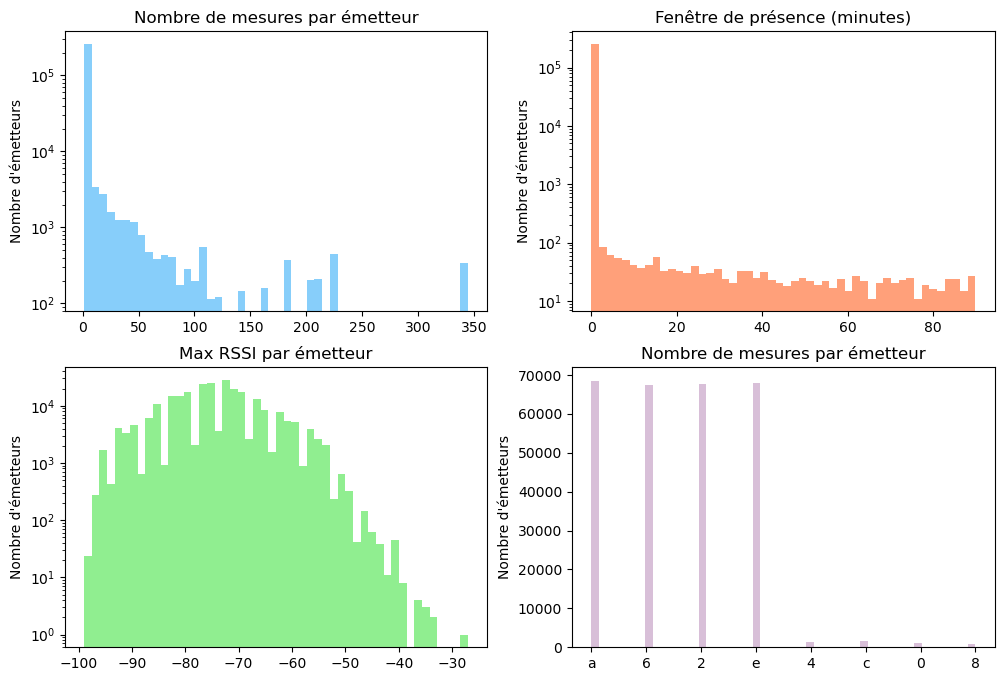

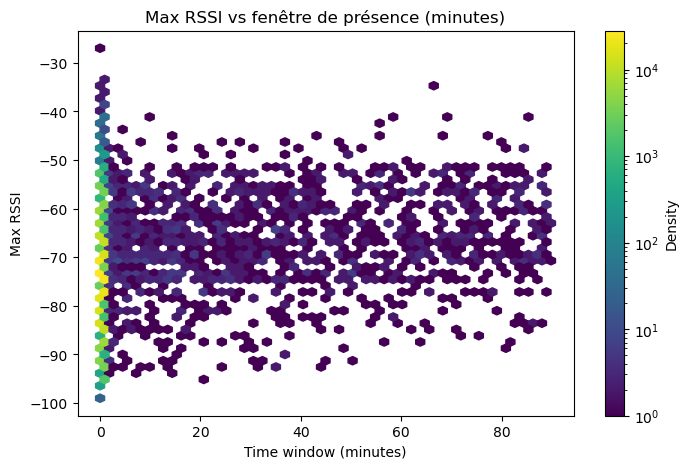

In [55]:

plot_metrics(df)


Application des filtres définis préalablement :
 * Au moins 2 observations par émetteur
 * Le deuxième caractère de l'identifiant doit uniquement contenir "a", "e", "2" ou "6" 
 * Le RSSI doit être supérieur à -60
 * (retiré) Le temps de présence doit être compris entre 1 et 60 secondes.
 * (manquant) Filtre sur les OUI d'appareils connus (https://standards-oui.ieee.org/)


In [56]:
print_stats_small(df)
df = df[df["nb_counts"] >= 2]
print_stats_small(df)
df = df[df['digit_2'].isin(['2', '6', 'a', 'e'])]
print_stats_small(df)
df = df[df['max_rssi'] > -60]
print_stats_small(df)   
#df1 = df[(df["time_window"] < 15*60) & (df["time_window"] > 1)]
#print_stats_small(df1)   
#df2 = df[(df["time_window"] > 1)]
#print_stats_small(df2)   




Nb. de lignes/émetteurs/récepteurs :   276562   254703        7
Nb. de lignes/émetteurs/récepteurs :    26363     4504        7
Nb. de lignes/émetteurs/récepteurs :    21735     4224        7
Nb. de lignes/émetteurs/récepteurs :     7537      522        7


Nombre d'émetteurs vus par chaque récepteur:

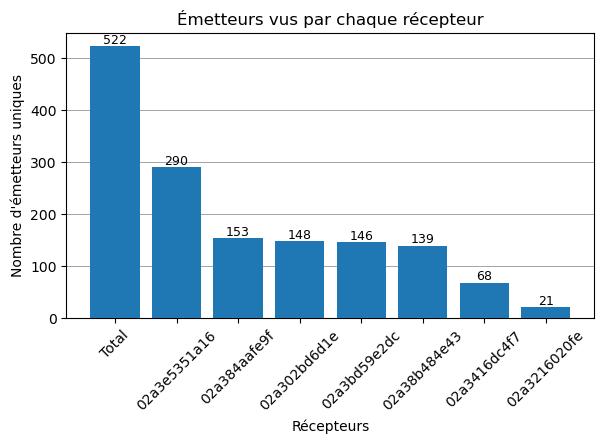

In [57]:
import matplotlib.pyplot as plt

receivers = df["receiverId"].unique()
counts = []


# Compute counts
receivers = df["receiverId"].unique().tolist()
counts = [df[df["receiverId"] == r]["transmitterId"].nunique() for r in receivers]

# Add Total
receivers.append("Total")
counts.append(df["transmitterId"].nunique())

# Create DataFrame to sort
df_counts = pd.DataFrame({"receiver": receivers, "count": counts})
df_counts = df_counts.sort_values(by="count", ascending=False)

fig, ax = plt.subplots()
bars = ax.bar(df_counts["receiver"].astype(str), df_counts["count"], zorder=3)
ax.grid(axis="y", linestyle="-", linewidth=0.5, color="gray", zorder=0)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,  # x position = center of bar
        height,                           # y position = top of bar
        str(height),                       # text
        ha="center", va="bottom",         # alignment
        fontsize=9
    )

ax.set_ylabel("Nombre d'émetteurs uniques")
ax.set_title("Émetteurs vus par chaque récepteur")
ax.set_xlabel("Récepteurs", labelpad=5)  # increase number for more space
plt.xticks(rotation=45)
plt.tight_layout(pad=2)
plt.show()




Taux de pénétration pour le nombre total d'émetteurs vus, pour une fréquentation de 352 000 personnes, soit environ 117 000 par jour, et 58 500 par demi-journée.
Le taux plus faible peut-être un indicateur de la pénétration d'une mesure sur une zone de transit (cas de la prise de mesure lors de la F1), contrairement à la mesure de Osheaga, prise sur une zone d'activité.

In [ ]:
nb_entrees = 352000 / (3 * 2) # sur un week-end, données pour une matinée
n_transmitters = df["transmitterId"].nunique()
ratio = round(100 * n_transmitters / nb_entrees ,2)
print(f"Ratio entrées/émetteurs: {ratio} %")


Ratio entrées/émetteurs: 0.59 %


In [24]:

folder = Path("../data/Osheaga-2022/Bornes/Banque-Nationale-Canada/")
file_names = [
    "BNC_29 juillet_1.csv",
    "BNC_30 juillet_1.csv",
    "BNC_31 juillet_1.csv",
    "BNC_29 juillet_2.csv",
    "BNC_30 juillet_2.csv",
    "BNC_31 juillet_2.csv"
]


dfs = {}
for f in file_names:
    # create a short name like 'BNC_29_1'
    key = f.replace(" juillet", "").replace(".csv", "").replace(" ", "_")
    dfs[key] = pd.read_csv(folder / f)

In [25]:
for name, df in dfs.items():
    print(f"Sample from {name}:")
    print(df.head(2))
    print("-" * 20)
    print_stats(df)
    print("-" * 40)


Sample from BNC_29_1:
     receiverId  rssi                    timestamp transmitterId
0  02a3ea43126e   -79  Jul 29, 2022 @ 19:29:59.676  62bb06605ade
1  02a3ea43126e   -58  Jul 29, 2022 @ 19:29:59.676  86dc12fbaddd
--------------------
Nombre de lignes : 253584
Nombre d'émetteurs uniques : 184730
Nombre de récepteurs uniques : 5
Date/heure min : Jul 29, 2022 @ 13:00:00.369
Date/heure max : Jul 29, 2022 @ 19:29:59.676
----------------------------------------
Sample from BNC_30_1:
     receiverId  rssi                    timestamp transmitterId
0  02a3ea43126e   -75  Jul 30, 2022 @ 19:52:54.287  ca46e331f2b4
1  02a3ea43126e   -69  Jul 30, 2022 @ 19:52:53.284  d21e5b863721
--------------------
Nombre de lignes : 142465
Nombre d'émetteurs uniques : 127357
Nombre de récepteurs uniques : 1
Date/heure min : Jul 30, 2022 @ 13:00:00.017
Date/heure max : Jul 30, 2022 @ 19:52:54.287
----------------------------------------
Sample from BNC_31_1:
     receiverId  rssi                    timestamp

In [26]:
for name, df in dfs.items():
    dfs[name] = wrangle_data(df)


In [27]:
for name, df in dfs.items():
    dfs[name] = build_metrics(df)


Calculating number of measurements per transmitter...
Calculating time window and max RSSI per transmitter...
Extracting second character of transmitterId...
Calculating number of measurements per transmitter...
Calculating time window and max RSSI per transmitter...
Extracting second character of transmitterId...
Calculating number of measurements per transmitter...
Calculating time window and max RSSI per transmitter...
Extracting second character of transmitterId...
Calculating number of measurements per transmitter...
Calculating time window and max RSSI per transmitter...
Extracting second character of transmitterId...
Calculating number of measurements per transmitter...
Calculating time window and max RSSI per transmitter...
Extracting second character of transmitterId...
Calculating number of measurements per transmitter...
Calculating time window and max RSSI per transmitter...
Extracting second character of transmitterId...


La borne 1 du 29 semble avoir des mesures outliers particulières à filtrer. On observe une différence systématique et persistente entre les deux bornes, ainsi que des similarités entre les trois jours.

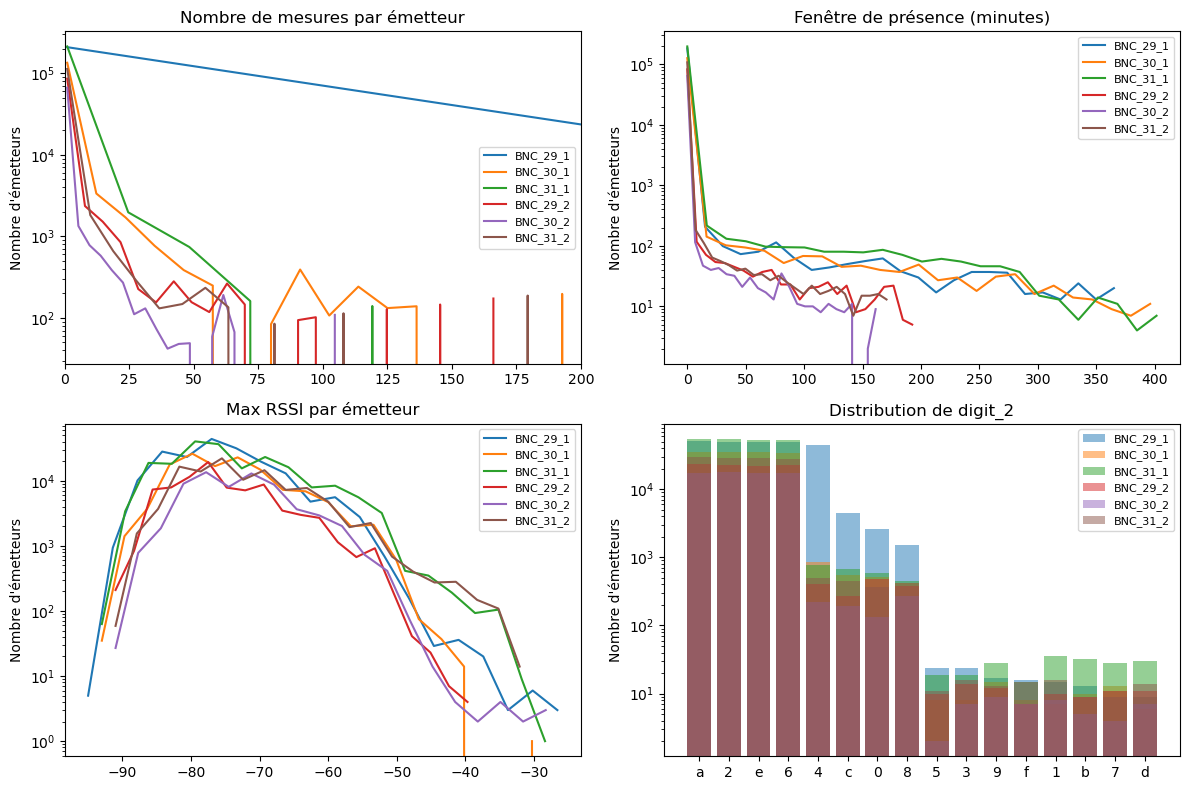

In [28]:
plot_metrics_multi(dfs)

In [29]:
for name, df in dfs.items():
    print("-" * 40)
    print(f"Filtering {name}:")
    print_stats_small(df)
    df = df[df["nb_counts"] >= 2]
    print_stats_small(df)
    df = df[df['digit_2'].isin(['2', '6', 'a', 'e'])]
    print_stats_small(df)
    df = df[df['max_rssi'] > -60]
    print_stats_small(df)   
    dfs[name] = df
#df1 = df[(df["time_window"] < 15*60) & (df["time_window"] > 1)]
#print_stats_small(df1)   
#df2 = df[(df["time_window"] > 1)]
#print_stats_small(df2)   




----------------------------------------
Filtering BNC_29_1:
Nb. de lignes/émetteurs/récepteurs :   253584   184730        5
Nb. de lignes/émetteurs/récepteurs :    71905     3051        5
Nb. de lignes/émetteurs/récepteurs :    18591     2688        5
Nb. de lignes/émetteurs/récepteurs :     6405      535        5
----------------------------------------
Filtering BNC_30_1:
Nb. de lignes/émetteurs/récepteurs :   142465   127357        1
Nb. de lignes/émetteurs/récepteurs :    17540     2432        1
Nb. de lignes/émetteurs/récepteurs :    15427     2230        1
Nb. de lignes/émetteurs/récepteurs :     5588      455        1
----------------------------------------
Filtering BNC_31_1:
Nb. de lignes/émetteurs/récepteurs :   217612   198665        1
Nb. de lignes/émetteurs/récepteurs :    22400     3453        1
Nb. de lignes/émetteurs/récepteurs :    20305     3172        1
Nb. de lignes/émetteurs/récepteurs :     9070      777        1
----------------------------------------
Filterin

Nombre d'émetteurs-jours vus au total par chaque borne:

In [ ]:
dfs_1 = {name: df for name, df in dfs.items() if "_1" in name}
transmitters_day_1 = 0
for name, df in dfs_1.items():
    transmitters_day_1 += df["transmitterId"].nunique()
print(f"Émetteurs-jour pour la borne 1: {transmitters_day_1}")

dfs_2 = {name: df for name, df in dfs.items() if "_2" in name}
transmitters_day_2 = 0
for name, df in dfs_2.items():
    transmitters_day_2 += df["transmitterId"].nunique()
print(f"Émetteurs-jour pour la borne 2: {transmitters_day_2}")



Émetteurs-jour pour la borne 1: 1767
Émetteurs-jour pour la borne 2: 1334


In [ ]:
df_1_merged = pd.concat(dfs_1.values(), ignore_index=True)
transmitters_1 = df_1_merged["transmitterId"].nunique()
print(f"Émetteurs pour la borne 1: {transmitters_1}")

# redo for 2
df_2_merged = pd.concat(dfs_2.values(), ignore_index=True) 
transmitters_2 = df_2_merged["transmitterId"].nunique()
print(f"Émetteurs pour la borne 2: {transmitters_2}")   

Émetteurs pour la borne 1: 1669
Émetteurs pour la borne 2: 1279


In [41]:
ratio_1 = round(transmitters_day_1 / transmitters_1,2)
ratio_2 = round(transmitters_day_2 / transmitters_2,2)  
print(f"Ratio de répetition pour la borne 1: {ratio_1}")
print(f"Ratio de répetition pour la borne 2: {ratio_2}")


Ratio de répetition pour la borne 1: 1.06
Ratio de répetition pour la borne 2: 1.04


In [47]:
nb_billets = 57187
penetration_1 = round(100 * transmitters_1 / nb_billets, 1)
penetration_2 = round(100 * transmitters_2 / nb_billets, 1)
print(f"Taux de pénétration-billets pour la borne 1: {penetration_1}%")
print(f"Taux de pénétration-billets pour la borne 2: {penetration_2}%")  

nb_entrees = 102936
penetration_1 = round(100 * transmitters_day_1 / nb_entrees, 1)
penetration_2 = round(100 * transmitters_day_2 / nb_entrees, 1)
print(f"Taux de pénétration-entrées pour la borne 1: {penetration_1}%")
print(f"Taux de pénétration-entrées pour la borne 2: {penetration_2}%")  


Taux de pénétration-billets pour la borne 1: 2.9%
Taux de pénétration-billets pour la borne 2: 2.2%
Taux de pénétration-entrées pour la borne 1: 1.7%
Taux de pénétration-entrées pour la borne 2: 1.3%
